In [ ]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn import svm

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
#import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

rng = default_rng(seed=42)

## Load quasar tables

# Gaia quasar candidates in SDSS footprint

In [22]:
fn_xsdssfootprint = '../data/gaia_candidates_xsdssfootprint.fits'
tab_gcand_xsdssfootprint = utils.load_table(fn_xsdssfootprint)
print(f"Number of Gaia quasar candidates in SDSS footprint: {len(tab_gcand_xsdssfootprint)}")

Number of Gaia quasar candidates in SDSS footprint: 574563


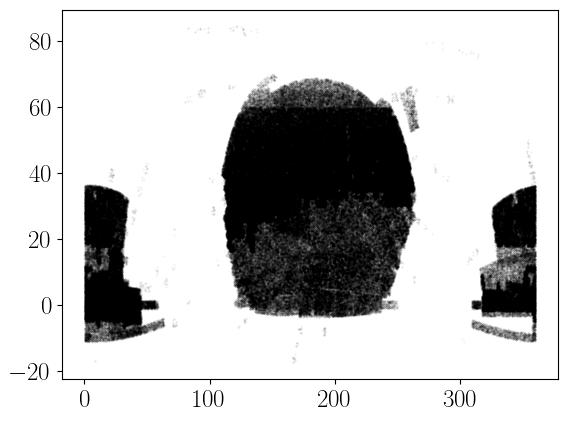

In [24]:
plt.scatter(tab_gcand_xsdssfootprint['ra'], tab_gcand_xsdssfootprint['dec'], color='k', alpha=0.1, s=0.1)

In [36]:
fn_squasars_xgaiaall = '../data/quasars_sdss_xgaia_xunwise_all.csv'
tab_squasars_xgaiaall = utils.load_table(fn_squasars, format='csv')
print(len(tab_squasars))

405485


In [39]:
fn_gcand = '../data/gaia_candidates_plus.fits.gz'
tab_gcand = utils.load_table(fn_gcand)
N_data_gcand = len(tab_gcand)
print(f"Number of all Gaia quasar candidates: {N_data_gcand}")

Number of all Gaia quasar candidates: 6649162


In [40]:
i_squasars_ingcand = np.isin(tab_squasars_xgaiaall['t1_source_id'], tab_gcand['source_id'])
print(np.sum(i_squasars_ingcand))
tab_squasars_xgaiacand = tab_squasars_xgaiaall[i_squasars_ingcand]

327099


In [41]:
# this should be 1 by definition
i_squasar_ingcandxfoot = np.isin(tab_squasars_xgaiacand['t1_source_id'], tab_gcand_xsdssfootprint['source_id'])
print(np.sum(i_squasar_ingcandxfoot)/len(i_squasar_ingcandxfoot)) # hum why is this not 100%

1.0


In [42]:
i_insquasar = np.isin(tab_gcand_xsdssfootprint['source_id'], tab_squasars_xgaiacand['t1_source_id'])
print(np.sum(i_insquasar))

327098


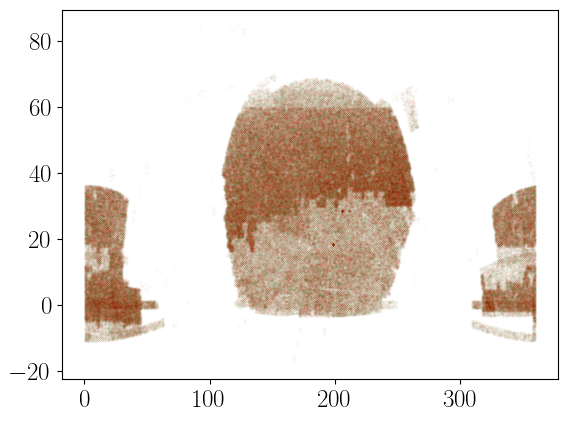

In [43]:
idx_rand = rng.choice(np.arange(len(tab_gcand_xsdssfootprint)), size=len(tab_gcand_xsdssfootprint), replace=False)
# random order so no ordered plotting effects
ra_randord = tab_gcand_xsdssfootprint['ra'][idx_rand]
dec_randord = tab_gcand_xsdssfootprint['dec'][idx_rand]


plt.scatter(ra_randord[i_insquasar], dec_randord[i_insquasar], 
            color='g', alpha=0.1, s=0.01)
plt.scatter(ra_randord[~i_insquasar], dec_randord[~i_insquasar], 
            color='r', alpha=0.1, s=0.01)

In [44]:
tab_gcand_xsdssfootprint.columns

<TableColumns names=('source_id','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','pmra','pmra_error','pmdec','pmdec_error','parallax','parallax_error','ebv','A_v','pm','rand_ints')>

Text(0, 0.5, 'normalized number per bin')

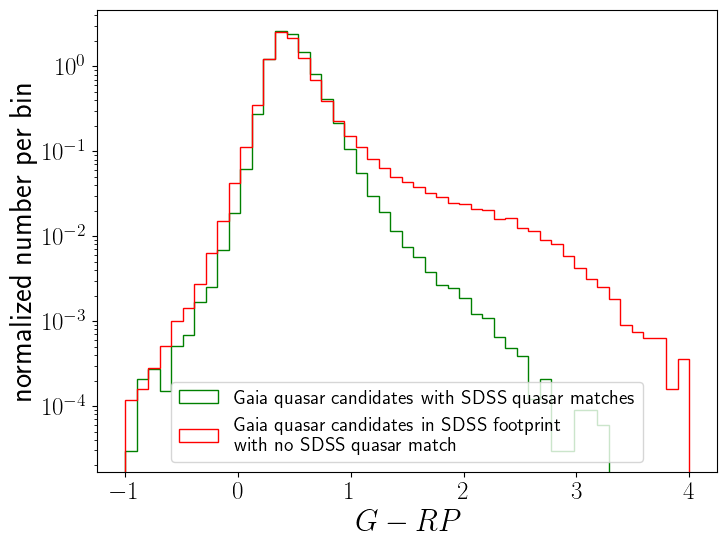

In [59]:
plt.figure(figsize=(8,6))
tabs = [tab_gcand_xsdssfootprint[i_insquasar], tab_gcand_xsdssfootprint[~i_insquasar]]
colors = ['g', 'r']
labels = ['Gaia quasar candidates with SDSS quasar matches', 
          'Gaia quasar candidates in SDSS footprint\nwith no SDSS quasar match']
bins = np.linspace(-1, 4, 50)
for i, tab in enumerate(tabs):
    plt.hist(tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'], histtype='step',
                color=colors[i], label=labels[i], bins=bins, density=True)
plt.legend(loc='best', fontsize=14)
plt.yscale('log')

plt.xlabel(r'$G-RP$')
plt.ylabel('normalized number per bin')

Text(0, 0.5, 'normalized number per bin')

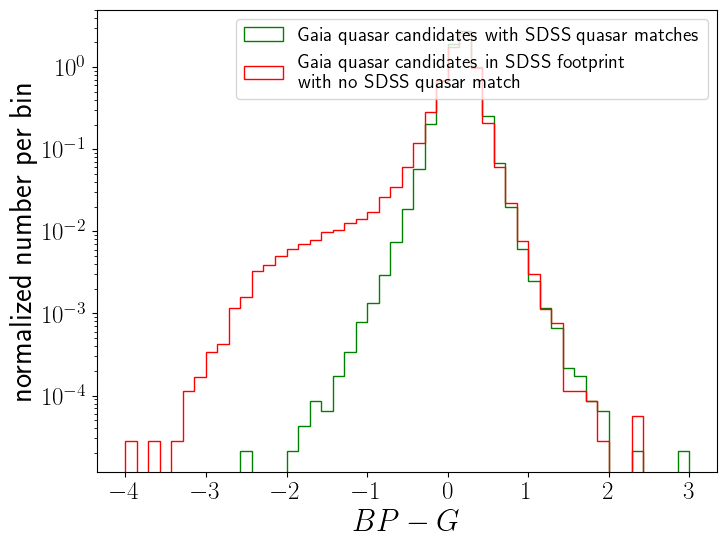

In [63]:
plt.figure(figsize=(8,6))
tabs = [tab_gcand_xsdssfootprint[i_insquasar], tab_gcand_xsdssfootprint[~i_insquasar]]
colors = ['g', 'r']
labels = ['Gaia quasar candidates with SDSS quasar matches', 
          'Gaia quasar candidates in SDSS footprint\nwith no SDSS quasar match']
bins = np.linspace(-4, 3, 50)
for i, tab in enumerate(tabs):
    plt.hist(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], histtype='step',
                color=colors[i], label=labels[i], bins=bins, density=True)
plt.legend(loc='best', fontsize=14)
plt.yscale('log')

plt.xlabel(r'$BP-G$')
plt.ylabel('normalized number per bin')

Text(0, 0.5, '$G-RP$')

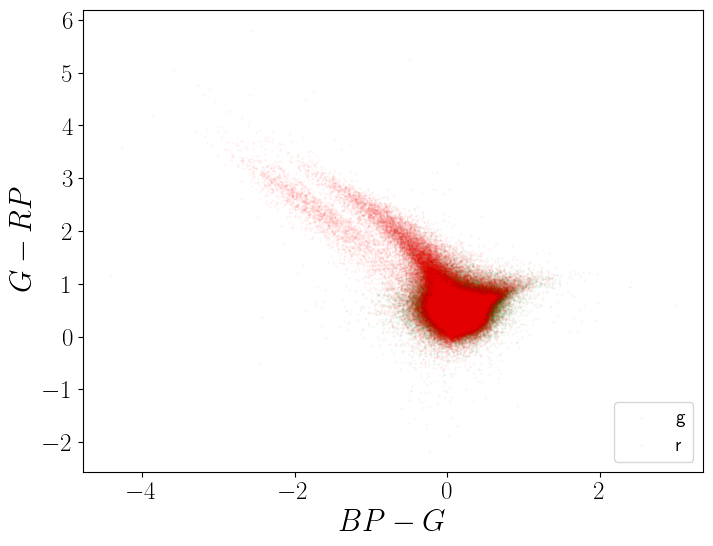

In [51]:
plt.figure(figsize=(8,6))
tabs = [tab_gcand_xsdssfootprint[i_insquasar], tab_gcand_xsdssfootprint[~i_insquasar]]
colors = ['g', 'r']
labels = ['g', 'r']
for i, tab in enumerate(tabs):
#     plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
#                 color=colors[i], label=labels[i], alpha=0.1, s=1)
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], 
                tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.1, s=0.1)
plt.legend(loc='lower right', fontsize=(14))
#plt.xlim(-1, 13)
#plt.ylim(-2, 3)

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-RP$')